# 브라질 E-Commerce 시장의 state별 재구매 카테고리 예측

## 1. Data 전처리

In [70]:
import numpy as np
import pandas as pd

#필요한 데이터 로드
customers = pd.read_csv('./olist_customers_dataset.csv')
order_items = pd.read_csv('./olist_order_items_dataset.csv')
order_payments = pd.read_csv('./olist_order_payments_dataset.csv')
reviews = pd.read_csv('./olist_order_reviews_dataset.csv')
orders = pd.read_csv('./olist_orders_dataset.csv')
products = pd.read_csv('./olist_products_dataset.csv')
translation = pd.read_csv('./product_category_name_translation.csv')


In [71]:
#데이터 병합
rebuy = pd.merge(orders, order_items, on='order_id', how='left').merge(customers, on = 'customer_id')[['customer_unique_id', 'product_id']].value_counts()

rebuy

customer_unique_id                product_id                      
c8460e4251689ba205045f3ea17884a1  e7cc48a9daff5436f63d3aad9426f28b    24
c402f431464c72e27330a67f7b94d4fb  ee3d532c8a438679776d222e997606b3    20
698e1cf81d01a3d389d96145f7fa6df8  9571759451b1d780ee7c15012ea109d4    20
0f5ac8d5c31de21d2f25e24be15bbffb  89b190a046022486c635022524a974a8    15
11f97da02237a49c8e783dfda6f50e8e  37eb69aca8718e843d897aa7b82f462d    15
                                                                      ..
ffe8f2fc0cee48f79934bd2c506fafc0  6843fcf2daa799e469f08d9ded452d01     1
ffe9102bb78a76921ba0ff3c4659616a  7acc602a5598de7992eb7d3b4e080b7d     1
0a035d8e44a6712f93ad10da223c228e  43423cdffde7fda63d0414ed38c11a73     1
ffe96c782a5bc522bd8bad3bc638981a  ddceb6eef6af67e9fbbd4c148dbe5fd9     1
ffddf4e5baa1623f69d3c5e0d775e1af  ebe731afbcf530cfaa1e5260be512e9b     1
Name: count, Length: 101987, dtype: int64

### 사용할 컬럼
* orders.csv
  * order_id 🗝️
  * customer_id 🗝️

* customers.csv
  * customer_id 🗝️
  * customer_unique_id
  
* order_itmes.csv
  * order_id 🗝️
  * order_item_id
  * product_id 🗝️
  * price
  * freigt_value

* products.csv
  * product_id 🗝️
  * product_photos_qty
  * product_description_lenght
  * product_name_lenght
  * product_category_name 🗝️

* reviews.csv
  * order_id 🗝️
  * review_id
  * review_score

* category_translation.csv
  * product_category_name 🗝️
  * product_category_name_english
  

In [72]:
#필요한 칼럼 위주로 데이터 병합
merge_data = pd.merge(
        orders[['order_id', 'customer_id']],
        customers[['customer_id', 'customer_unique_id']], on = 'customer_id', how= 'left'
    ).merge(
        order_items[['order_id', 'order_item_id', 'product_id', 'price', 'freight_value']], on = 'order_id', how= 'left'
    ).merge(
        reviews[['order_id', 'review_id', 'review_score']], on = 'order_id', how= 'left'
    ).merge(
        products[['product_id', 'product_photos_qty', 'product_description_lenght', 'product_name_lenght', 'product_category_name']], on = 'product_id', how = 'left'
    ).merge(
        translation[['product_category_name', 'product_category_name_english']], on = 'product_category_name', how = 'left'
  )

In [73]:
#포르투갈어 카테고리명 제거
merge_data.drop('product_category_name', axis = 1, inplace = True)

In [74]:
#영어 카테고리명 추가
merge_data['product_category_name_english'].unique()

array(['housewares', 'perfumery', 'auto', 'pet_shop', 'stationery', nan,
       'furniture_decor', 'office_furniture', 'garden_tools',
       'computers_accessories', 'bed_bath_table', 'toys',
       'construction_tools_construction', 'telephony', 'health_beauty',
       'electronics', 'baby', 'cool_stuff', 'watches_gifts',
       'air_conditioning', 'sports_leisure', 'books_general_interest',
       'small_appliances', 'food', 'luggage_accessories',
       'fashion_underwear_beach', 'christmas_supplies',
       'fashion_bags_accessories', 'musical_instruments',
       'construction_tools_lights', 'books_technical',
       'costruction_tools_garden', 'home_appliances', 'market_place',
       'agro_industry_and_commerce', 'party_supplies', 'home_confort',
       'cds_dvds_musicals', 'industry_commerce_and_business',
       'consoles_games', 'furniture_bedroom', 'construction_tools_safety',
       'fixed_telephony', 'drinks',
       'kitchen_dining_laundry_garden_furniture', 'fashion_sho

In [75]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   customer_unique_id             114092 non-null  object 
 3   order_item_id                  113314 non-null  float64
 4   product_id                     113314 non-null  object 
 5   price                          113314 non-null  float64
 6   freight_value                  113314 non-null  float64
 7   review_id                      113131 non-null  object 
 8   review_score                   113131 non-null  float64
 9   product_photos_qty             111702 non-null  float64
 10  product_description_lenght     111702 non-null  float64
 11  product_name_lenght            111702 non-null  float64
 12  product_category_name_english 

In [76]:
#고객 id + 상품 id로 그룹화한 뒤 구매 횟수 카운트 (2이상 값이면 재구매)
merge_data['purchase_cnt'] = (
    merge_data
    .groupby(['customer_unique_id', 'product_id'])['customer_unique_id']
    .transform('count')
)

In [77]:
#재구매면 1, 아니면 0
merge_data['repurchase'] = merge_data['purchase_cnt'].apply(lambda x: 1 if x > 1 else 0)

In [78]:
# 상위 카테고리 추가

category_mapping = {
    # 🏠 생활/가정
    "housewares": "Home & Living",
    "furniture_decor": "Home & Living",
    "furniture_bedroom": "Home & Living",
    "furniture_living_room": "Home & Living",
    "furniture_mattress_and_upholstery": "Home & Living",
    "office_furniture": "Home & Living",
    "bed_bath_table": "Home & Living",
    "kitchen_dining_laundry_garden_furniture": "Home & Living",
    "home_appliances": "Home & Living",
    "home_appliances_2": "Home & Living",
    "small_appliances": "Home & Living",
    "small_appliances_home_oven_and_coffee": "Home & Living",
    "home_confort": "Home & Living",
    "home_comfort_2": "Home & Living",
    "home_construction": "Home & Living",
    "garden_tools": "Home & Living",
    "costruction_tools_garden": "Home & Living",
    "construction_tools_construction": "Home & Living",
    "construction_tools_lights": "Home & Living",
    "construction_tools_safety": "Home & Living",
    "costruction_tools_tools": "Home & Living",
    "air_conditioning": "Home & Living",

    # 💄 패션/뷰티
    "fashion_male_clothing": "Fashion & Beauty",
    "fashio_female_clothing": "Fashion & Beauty",
    "fashion_childrens_clothes": "Fashion & Beauty",
    "fashion_shoes": "Fashion & Beauty",
    "fashion_underwear_beach": "Fashion & Beauty",
    "fashion_bags_accessories": "Fashion & Beauty",
    "fashion_sport": "Fashion & Beauty",
    "watches_gifts": "Fashion & Beauty",
    "health_beauty": "Fashion & Beauty",
    "perfumery": "Fashion & Beauty",
    "luggage_accessories": "Fashion & Beauty",

    # 🧸 취미/엔터테인먼트
    "toys": "Entertainment & Leisure",
    "cool_stuff": "Entertainment & Leisure",
    "sports_leisure": "Entertainment & Leisure",
    "consoles_games": "Entertainment & Leisure",
    "cine_photo": "Entertainment & Leisure",
    "music": "Entertainment & Leisure",
    "cds_dvds_musicals": "Entertainment & Leisure",
    "dvds_blu_ray": "Entertainment & Leisure",
    "art": "Entertainment & Leisure",
    "arts_and_craftmanship": "Entertainment & Leisure",
    "musical_instruments": "Entertainment & Leisure",
    "books_general_interest": "Entertainment & Leisure",
    "books_technical": "Entertainment & Leisure",
    "books_imported": "Entertainment & Leisure",
    "party_supplies": "Entertainment & Leisure",
    "christmas_supplies": "Entertainment & Leisure",

    # 💻 전자/디지털
    "computers": "Electronics & Digital",
    "computers_accessories": "Electronics & Digital",
    "tablets_printing_image": "Electronics & Digital",
    "electronics": "Electronics & Digital",
    "audio": "Electronics & Digital",
    "telephony": "Electronics & Digital",
    "fixed_telephony": "Electronics & Digital",
    "signaling_and_security": "Electronics & Digital",
    "security_and_services": "Electronics & Digital",

    # 👶 유아/아동
    "baby": "Baby & Kids",
    "diapers_and_hygiene": "Baby & Kids",

    # 🍎 식품/주류
    "food": "Food & Beverages",
    "food_drink": "Food & Beverages",
    "drinks": "Food & Beverages",
    "agro_industry_and_commerce": "Food & Beverages",
    "la_cuisine": "Food & Beverages",
    "flowers": "Food & Beverages",

    # 📚 문구/사무
    "stationery": "Stationery & Office",
    "industry_commerce_and_business": "Stationery & Office",
    "market_place": "Stationery & Office",

    # other
    "pet_shop": "pet",
    'auto': 'auto',
    'market_place': 'market_place'
}


# 매핑 적용
merge_data["product_top_category"] = merge_data["product_category_name_english"].map(category_mapping).fillna("Other")

print(merge_data)

                                order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
114087  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
114088  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
114089  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
114090  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
114091  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

                      customer_unique_id  order_item_id  \
0   

In [79]:
#결측치 재확인
merge_data.isnull().mean()

order_id                         0.000000
customer_id                      0.000000
customer_unique_id               0.000000
order_item_id                    0.006819
product_id                       0.006819
price                            0.006819
freight_value                    0.006819
review_id                        0.008423
review_score                     0.008423
product_photos_qty               0.020948
product_description_lenght       0.020948
product_name_lenght              0.020948
product_category_name_english    0.021158
purchase_cnt                     0.006819
repurchase                       0.000000
product_top_category             0.000000
dtype: float64

In [80]:
#결측치 제거
merge_data = merge_data.dropna()

In [81]:
#merge_data.csv 저장
merge_data.to_csv('./merge_data.csv', index = False)

In [82]:
#고객의 거주 state 데이터 추가

df1 = pd.read_csv("./merge_data.csv")
df2 = pd.read_csv("./olist_customers_dataset.csv")[["customer_id", "customer_state"]]

#customer_id 기준으로 병합
df = pd.merge(df1, df2, on="customer_id", how="left")

df.to_csv("./merge_data_2.csv", index=False)

In [83]:
print(df1.columns.tolist())
print(df2.columns.tolist())
print(df.columns.tolist())   # merge 후

['order_id', 'customer_id', 'customer_unique_id', 'order_item_id', 'product_id', 'price', 'freight_value', 'review_id', 'review_score', 'product_photos_qty', 'product_description_lenght', 'product_name_lenght', 'product_category_name_english', 'purchase_cnt', 'repurchase', 'product_top_category']
['customer_id', 'customer_state']
['order_id', 'customer_id', 'customer_unique_id', 'order_item_id', 'product_id', 'price', 'freight_value', 'review_id', 'review_score', 'product_photos_qty', 'product_description_lenght', 'product_name_lenght', 'product_category_name_english', 'purchase_cnt', 'repurchase', 'product_top_category', 'customer_state']


In [84]:
#모델링 방해하는 불필요한 칼럼 list
drop_cols = [
    "order_id",          # 주문 ID
    "customer_unique_id", # 고객 고유 ID
    "customer_id",       # 고객 ID
    "product_id",        # 상품 ID
    "review_id",         # 리뷰 ID
    "order_item_id",     # 주문당 아이템 넘버
    "purchase_cnt",       # 라벨 생성에 쓰인 변수 (누수 위험)
]

merge_data_2 = pd.read_csv('./merge_data_2.csv')

#X(feature), y(target) 분리
X = merge_data_2.drop(columns=drop_cols + ["repurchase"])
y = merge_data_2["repurchase"]

#불필요한 칼럼 제거 후 최종 데이터셋 저장
merge_data_fin = merge_data_2.drop(columns=drop_cols, errors='ignore')
merge_data_fin.to_csv('./merge_data_fin.csv', index = False)

In [85]:
print(merge_data_fin.head(10))

    price  freight_value  review_score  product_photos_qty  \
0   29.99           8.72           4.0                 4.0   
1  118.70          22.76           4.0                 1.0   
2  159.90          19.22           5.0                 1.0   
3   45.00          27.20           5.0                 3.0   
4   19.90           8.72           5.0                 4.0   
5  147.90          27.36           4.0                 1.0   
6   59.99          15.17           5.0                 1.0   
7   19.90          16.05           1.0                 2.0   
8  149.99          19.77           5.0                 1.0   
9   99.00          30.53           1.0                 1.0   

   product_description_lenght  product_name_lenght  \
0                       268.0                 40.0   
1                       178.0                 29.0   
2                       232.0                 46.0   
3                       468.0                 59.0   
4                       316.0                 3

## 2. Modeling

### 1. 로지스틱 회귀 (Baseline)

In [86]:
import pandas as pd
merge_data_cleaned = pd.read_csv("./merge_data_fin.csv")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

#카테고리 결측을 'missing'으로 채우기
merge_data_cleaned["product_category_name_english"] = merge_data_cleaned["product_category_name_english"].fillna("missing")

#X(Feature), y(Target) 분리
X = merge_data_cleaned[[
    "price", 
    "freight_value", 
    "review_score", 
    "product_photos_qty", 
    "product_description_lenght", 
    "product_name_lenght", 
    "product_category_name_english"
]]
y = merge_data_cleaned["repurchase"]


#product 카테고리에 대해 One-Hot 인코딩 적용
X_encoded = pd.get_dummies(X, columns=["product_category_name_english"], drop_first=True)

#인코딩 결과 확인
print("인코딩 전 shape:", X.shape)
print("인코딩 후 shape:", X_encoded.shape)
print("인코딩된 칼럼 일부:\n", X_encoded.columns[:15])

#수치형 결측을 평균값으로 대체
imputer = SimpleImputer(strategy="mean")
X_encoded = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

#모델 학습
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

#예측
y_pred = model.predict(X_test)

#성능 평가
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

인코딩 전 shape: (110750, 7)
인코딩 후 shape: (110750, 76)
인코딩된 칼럼 일부:
 Index(['price', 'freight_value', 'review_score', 'product_photos_qty',
       'product_description_lenght', 'product_name_lenght',
       'product_category_name_english_air_conditioning',
       'product_category_name_english_art',
       'product_category_name_english_arts_and_craftmanship',
       'product_category_name_english_audio',
       'product_category_name_english_auto',
       'product_category_name_english_baby',
       'product_category_name_english_bed_bath_table',
       'product_category_name_english_books_general_interest',
       'product_category_name_english_books_imported'],
      dtype='object')
Baseline Accuracy: 0.6285778781038375

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.62      0.73     18406
           1       0.26      0.67      0.38      3744

    accuracy                           0.63     22150
   macro avg       0.58      

C:\Users\nsjic\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### Logistic Regression Confusion Matrix

Confusion Matrix (counts):
 [[11407  6999]
 [ 1228  2516]]


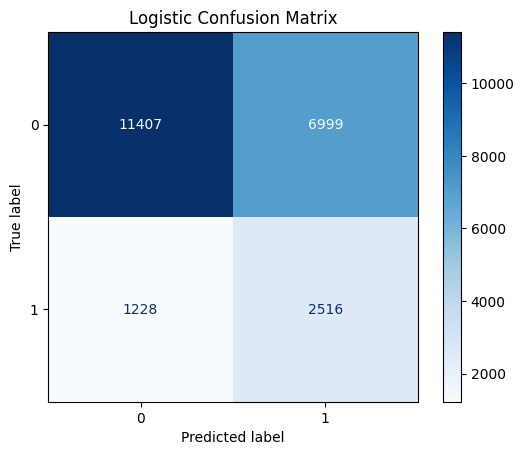

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Confusion Matrix 수치
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("Confusion Matrix (counts):\n", cm)

# 2) 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="Blues")
plt.title("Logistic Confusion Matrix")
plt.show()


### 2. CatBoost

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier


#데이터 불러오기
merge_data_fin = pd.read_csv('./merge_data_fin.csv')

#X(feature), y(target) 분리
y = merge_data_fin['repurchase'].astype(int)    #이진분류
X = merge_data_fin.drop(columns=['repurchase'])

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

#훈련/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#모델 학습
model = CatBoostClassifier(
    cat_features=cat_features,
    random_state=42,
    verbose=0
)
model.fit(X_train, y_train)

#예측
y_pred = model.predict(X_test)

#성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred))

Accuracy: 0.8552595936794583

혼동 행렬 (Confusion Matrix):
 [[18153   253]
 [ 2953   791]]

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     18406
           1       0.76      0.21      0.33      3744

    accuracy                           0.86     22150
   macro avg       0.81      0.60      0.62     22150
weighted avg       0.84      0.86      0.82     22150



#### CatBoost Confusion Matrix

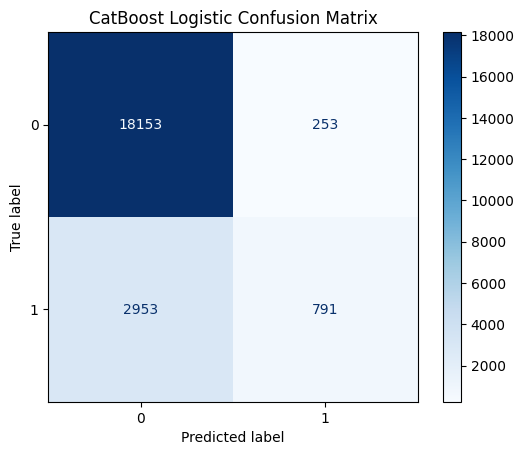

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

plt.title("CatBoost Logistic Confusion Matrix")
plt.show()

#### CatBoost 지도 시각화

In [ ]:
#재구매(class1) 확률 컬럼 추가
# 예측 확률
y_prob = model.predict_proba(X_test)[:, 1]  # class=1(재구매)의 확률만 추출

# 확률 컬럼 추가
X_test = X_test.copy()  # SettingWithCopyWarning 방지
X_test['repurchase_prob'] = y_prob

X_test.head(10)

,price,freight_value,review_score,product_photos_qty,product_description_lenght,product_name_lenght,product_category_name_english,product_top_category,customer_state,repurchase_prob
79973,37.00,20.80,5.0,4.0,322.0,44.0,watches_gifts,Fashion & Beauty,BA,0.105752
34155,69.00,29.63,1.0,1.0,264.0,45.0,computers_accessories,Electronics & Digital,SP,0.528451
48796,149.00,16.80,1.0,5.0,419.0,58.0,toys,Entertainment & Leisure,ES,0.054625
46393,128.99,21.29,5.0,1.0,111.0,42.0,bed_bath_table,Home & Living,RJ,0.215383
48660,189.00,24.25,5.0,1.0,232.0,34.0,computers_accessories,Electronics & Digital,RJ,0.602143
43952,76.50,26.84,1.0,2.0,930.0,22.0,housewares,Home & Living,PR,0.447464
105497,36.50,14.08,5.0,2.0,1054.0,60.0,furniture_living_room,Home & Living,SP,0.389208
74211,34.90,22.06,1.0,1.0,712.0,45.0,telephony,Electronics & Digital,BA,0.206126
25238,129.99,17.16,5.0,1.0,468.0,35.0,luggage_accessories,Fashion & Beauty,SP,0.037965
9656,27.90,7.46,5.0,1.0,295.0,49.0,health_beauty,Fashion & Beauty,SP,0.373027


In [91]:
#재구매 확률의 평균 계산하여 mean_prob 컬럼 생성
X_test['state_category_mean_prob'] = X_test.groupby(['customer_state', 'product_top_category'])['repurchase_prob'].transform('mean')
state_repurchase_top_categ = X_test.sort_values(["customer_state", "repurchase_prob"], ascending=False).drop_duplicates("customer_state")
state_repurchase_top_categ[['customer_state','product_top_category','state_category_mean_prob']]

,customer_state,product_top_category,state_category_mean_prob
24470,TO,Home & Living,0.237865
98885,SP,Fashion & Beauty,0.110677
10991,SE,Home & Living,0.317158
5024,SC,Electronics & Digital,0.179061
46600,RS,Home & Living,0.256193
16390,RR,Home & Living,0.201672
87835,RO,Home & Living,0.112633
47754,RN,pet,0.307855
68183,RJ,Stationery & Office,0.112127
85774,PR,Home & Living,0.266587


In [ ]:
import json
import pandas as pd
import plotly.express as px
import plotly.io as pio


pio.renderers.default = "vscode"

# GeoJSON 로드
with open(r"./brazil_geo.json", "r", encoding="utf-8") as f:
    br_states = json.load(f)

# 브라질 주 약어 → 풀네임 맵핑
state_map = {
    "AC": "Acre",
    "AL": "Alagoas",
    "AM": "Amazonas",
    "AP": "Amapá",
    "BA": "Bahia",
    "CE": "Ceará",
    "DF": "Distrito Federal",
    "ES": "Espírito Santo",
    "GO": "Goiás",
    "MA": "Maranhão",
    "MT": "Mato Grosso",
    "MS": "Mato Grosso do Sul",
    "MG": "Minas Gerais",
    "PA": "Pará",
    "PB": "Paraíba",
    "PR": "Paraná",
    "PE": "Pernambuco",
    "PI": "Piauí",
    "RJ": "Rio de Janeiro",
    "RN": "Rio Grande do Norte",
    "RS": "Rio Grande do Sul",
    "RO": "Rondônia",
    "RR": "Roraima",
    "SC": "Santa Catarina",
    "SP": "São Paulo",
    "SE": "Sergipe",
    "TO": "Tocantins"
}

# top1에 state_name 컬럼 추가
state_repurchase_top_categ["state_name"] = state_repurchase_top_categ["customer_state"].map(state_map)

# Choropleth 그리기 (GeoJSON의 'properties.name'과 매칭)
fig = px.choropleth(
    state_repurchase_top_categ,
    geojson=br_states,
    locations="state_name",
    featureidkey="properties.name",
    color="product_top_category",
    hover_data=["state_category_mean_prob"],
    title="Top1 Repurchase Category per State (Brazil)",
    color_discrete_sequence=px.colors.qualitative.Pastel1
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.show()

#### CatBoost ROC Curve

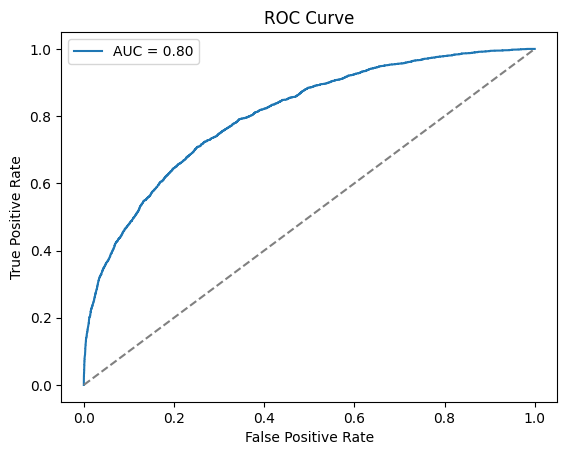

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

###

#### CatBoost 재구매율에 영향을 미치는 요인 

In [ ]:
from catboost import CatBoostClassifier, Pool

cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
# 모델 학습
model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, verbose=0)
model.fit(X_train, y_train, cat_features=cat_features)

# 중요도 계산
importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_features))
for col, val in zip(X_train.columns, importances):
    print(f"{col}: {val}")

price: 20.771147241934028
freight_value: 3.2629571957607837
review_score: 6.620620346059461
product_photos_qty: 8.538028341678983
product_description_lenght: 9.955683215578162
product_name_lenght: 4.997363346038964
product_category_name_english: 17.639077745127224
product_top_category: 27.46032501650295
customer_state: 0.7547975513194574


### 3. LightGBM + SMOTENC

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, f1_score
)

from imblearn.over_sampling import SMOTENC
from lightgbm import LGBMClassifier


data_final = pd.read_csv("./merge_data_fin.csv")

# 데이터 분리
drop_try = ['customer_id', 'repurchase']
X = data_final.drop(columns=[c for c in drop_try if c in data_final.columns]).copy()
y = data_final['repurchase'].astype(int).copy()

# 범주형/결측 처리
cat_cols = ['product_category_name_english', 'product_top_category', 'customer_state']
for c in cat_cols:
    if c in X.columns:
        X[c] = X[c].astype('object').fillna('missing')

# 학습/평가 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ordinal 인코딩 (SMOTENC는 정수 인코딩 필요)
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

X_train_enc[cat_cols] = enc.fit_transform(X_train_enc[cat_cols])
X_test_enc[cat_cols]  = enc.transform(X_test_enc[cat_cols])

# SMOTENC (train에만 적용)
cat_idx = [X_train_enc.columns.get_loc(c) for c in cat_cols]

smote = SMOTENC(
    categorical_features=cat_idx,
    random_state=42,
    k_neighbors=5   # 데이터 상황 따라 조절 가능
)
X_train_bal, y_train_bal = smote.fit_resample(X_train_enc, y_train)

# LightGBM 학습
lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    subsample=0.9,
    colsample_bytree=0.9,
)
lgbm.fit(X_train_bal, y_train_bal)

# 확률 예측 & 임계값 최적화(F1 최대화)
y_prob = lgbm.predict_proba(X_test_enc)[:, 1]

prec, rec, ths = precision_recall_curve(y_test, y_prob)

# precision_recall_curve가 반환하는 ths는 마지막 점 하나가 부족하므로 길이 맞춰 F1 계산
f1s = []
for p, r in zip(prec[:-1], rec[:-1]):
    if (p + r) == 0:
        f1s.append(0)
    else:
        f1s.append(2 * p * r / (p + r))

best_idx = int(np.argmax(f1s))
best_threshold = ths[best_idx]
best_f1 = f1s[best_idx]

# 최적 임계값으로 이진화 및 평가
y_pred_opt = (y_prob >= best_threshold).astype(int)

print(f"[최적 임계값 기반 F1 최적화]")
print(f"- Best Threshold: {best_threshold:.4f}")
print(f"- Best F1 (from PR curve): {best_f1:.4f}\n")

print("정확도 (Accuracy):", accuracy_score(y_test, y_pred_opt))
print("\n혼동 행렬 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred_opt))
print("\n분류 보고서 (Classification Report):\n", classification_report(y_test, y_pred_opt, digits=4))


[LightGBM] [Info] Number of positive: 73623, number of negative: 73623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 147246, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[최적 임계값 기반 F1 최적화]
- Best Threshold: 0.4221
- Best F1 (from PR curve): 0.5078

정확도 (Accuracy): 0.8144018058690745

혼동 행렬 (Confusion Matrix):
 [[15918  2488]
 [ 1623  2121]]

분류 보고서 (Classification Report):
               precision    recall  f1-score   support

           0     0.9075    0.8648    0.8856     18406
           1     0.4602    0.5665    0.5078      3744

    accuracy                         0.8144     22150
   macro avg     0.6838    0.7157    0.6967     22150
weighted avg     0

#### LightGMB+SMOTENC Confusion Matrix

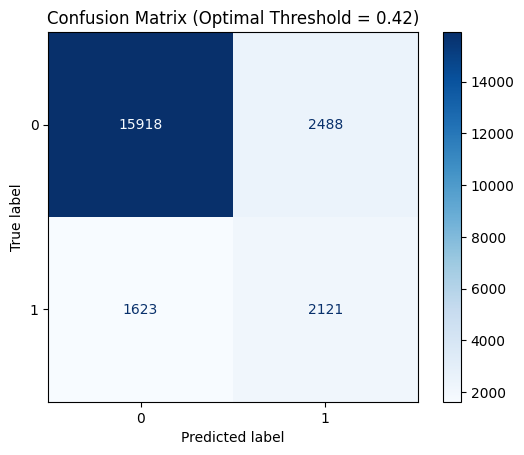

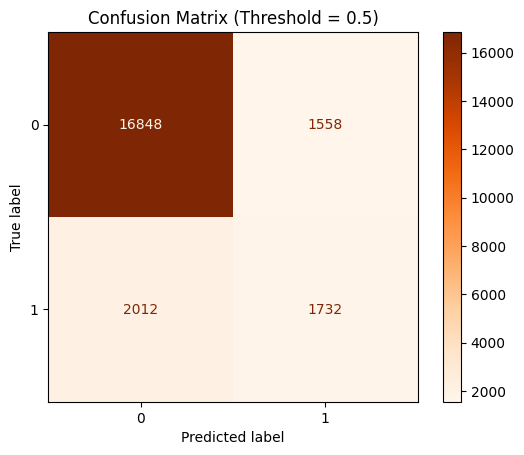

In [ ]:
#confusion matrix 시각화 (임계값 0.5 vs 최적 임계값 0.4221)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 최적 임계값 confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=lgbm.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Optimal Threshold = 0.42)")
plt.show()

# 0.5 임계값 confusion matrix
y_pred_05 = (y_prob >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_05, display_labels=lgbm.classes_)
disp2.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()


#### LightGBM+SMOTENC 지도 시각화

In [ ]:
#재구매(class1) 확률 컬럼 추가
X_test['repurchase_prob'] = y_prob
X_test.head(10)

In [ ]:
#재구매 확률의 평균 계산하여 mean_prob 컬럼 생성
X_test['state_category_mean_prob'] = X_test.groupby(['customer_state', 'product_top_category'])['repurchase_prob'].transform('mean')
state_repurchase_top_categ = X_test.sort_values(["customer_state", "repurchase_prob"], ascending=False).drop_duplicates("customer_state")
state_repurchase_top_categ[['customer_state','product_top_category','state_category_mean_prob']]

In [ ]:
import json
import pandas as pd
import plotly.express as px
import plotly.io as pio


pio.renderers.default = "vscode"

# GeoJSON 로드
with open(r"./brazil_geo.json", "r", encoding="utf-8") as f:
    br_states = json.load(f)

# 브라질 주 약어 → 풀네임 맵핑
state_map = {
    "AC": "Acre",
    "AL": "Alagoas",
    "AM": "Amazonas",
    "AP": "Amapá",
    "BA": "Bahia",
    "CE": "Ceará",
    "DF": "Distrito Federal",
    "ES": "Espírito Santo",
    "GO": "Goiás",
    "MA": "Maranhão",
    "MT": "Mato Grosso",
    "MS": "Mato Grosso do Sul",
    "MG": "Minas Gerais",
    "PA": "Pará",
    "PB": "Paraíba",
    "PR": "Paraná",
    "PE": "Pernambuco",
    "PI": "Piauí",
    "RJ": "Rio de Janeiro",
    "RN": "Rio Grande do Norte",
    "RS": "Rio Grande do Sul",
    "RO": "Rondônia",
    "RR": "Roraima",
    "SC": "Santa Catarina",
    "SP": "São Paulo",
    "SE": "Sergipe",
    "TO": "Tocantins"
}

# top1에 state_name 컬럼 추가
state_repurchase_top_categ["state_name"] = state_repurchase_top_categ["customer_state"].map(state_map)

# Choropleth 그리기 (GeoJSON의 'properties.name'과 매칭)
fig = px.choropleth(
    state_repurchase_top_categ,
    geojson=br_states,
    locations="state_name",
    featureidkey="properties.name",
    color="product_top_category",
    hover_data=["state_category_mean_prob"],
    title="Top1 Repurchase Category per State (Brazil)",
    color_discrete_sequence=px.colors.qualitative.Pastel1
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))
fig.show()

#### LightGBM+SMOTENC ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LightGBM+SMOTENC ROC Curve")
plt.legend()
plt.show()